In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
class Player(object):
    def __init__(self, currentSum, usableAce, dealersCard):
        self.currentSum = currentSum
        self.dealersCard = dealersCard
        self.usableAce = usableAce
        self.usingAce = self.usableAce

    def AddCard(self, card):
        if self.usingAce and self.currentSum + card > 21:
            self.usingAce = False
            self.currentSum += card - 10
        else:
            self.currentSum += card

    def Bust(self):
        return self.GetValue() > 21

    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)

    def GetValue(self):
        return self.currentSum

    def ShouldHit(self, policyMap):
        return policyMap[self.GetState()]
    


In [11]:
class Dealer(object):
    def __init__(self, cards):
        self.cards = cards

    def AddCard(self, card):
        self.cards.append(card)

    def Bust(self):
        return self.GetValue() > 21

    def GetValue(self):
        currentSum = 0
        aceCount = 0

        for card in self.cards:
            if card == 1:
                aceCount += 1
            else:
                currentSum += card

        while aceCount > 0:
            aceCount -= 1
            currentSum += 11

            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount
                break

        return currentSum
    
    def ShouldHit(self):
        if self.GetValue() >= 17:
            return False
        else:
            return True


In [12]:
class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = [ ]
        self.stateActionMap = set()

    def AddPair(self, pair):
        if pair in self.stateActionMap:
            return

        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)

In [13]:
def EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        actionValueMap[pair] = actionValueMap[pair] + ((reward - actionValueMap[pair]) / returns[pair])

        state = pair[0]
        shouldHit = False

        if actionValueMap[(state, True)] > actionValueMap[(state, False)]:
            shouldHit = True

        policyMap[state] = shouldHit



In [14]:
def GenerateCard():
    card = np.random.randint(1, 14)

    if card > 9:
        return 10
    else:
        return card

def GenerateStart(actionValueMap, policyMap, returns):
    playerSum = np.random.randint(11, 22)
    usableAce = bool(np.random.randint(0, 2))
    dealersCard1 = np.random.randint(1, 11)

    player = Player(playerSum, usableAce, dealersCard1)
    dealer = Dealer([ dealersCard1 ])

    stateActionInfo = StateActionInfo()
    shouldHit = bool(np.random.randint(0, 2))
    stateActionInfo.AddPair((player.GetState(), shouldHit))

    if shouldHit:
        player.AddCard(GenerateCard())

        while not player.Bust() and player.ShouldHit(policyMap):
            stateActionInfo.AddPair((player.GetState(), True))
            player.AddCard(GenerateCard())

    if player.Bust():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, -1)
        return

    stateActionInfo.AddPair((player.GetState(), False))
    dealer.AddCard(GenerateCard())

    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(GenerateCard())

    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, 1)
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, -1)
    else:
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, 0)


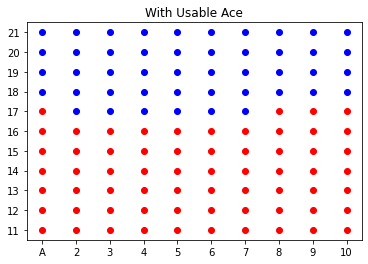

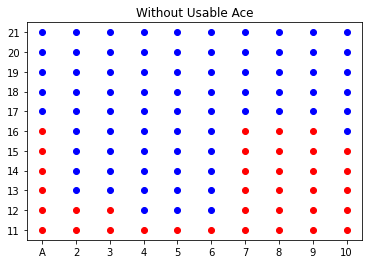

In [17]:
def PerformMonteCarloES():
    actionValueMap = { }
    policyMap = { }
    returns = { }

    for playerSum in range(11, 22):
        for usableAce in range(2):
            for dealersCard in range(1, 11):
                playerState = (playerSum, bool(usableAce), dealersCard)
                actionValueMap[(playerState, False)] = 0
                actionValueMap[(playerState, True)] = 0
                returns[(playerState, False)] = 0
                returns[(playerState, True)] = 0

                if playerSum == 20 or playerSum == 21:
                    policyMap[playerState] = False
                else:
                    policyMap[playerState] = True

    for i in range(2000000):
        GenerateStart(actionValueMap, policyMap, returns)

    x11 = [ ]
    y11 = [ ]

    x12 = [ ]
    y12 = [ ]

    x21 = [ ]
    y21 = [ ]

    x22 = [ ]
    y22 = [ ]

    for playerState in policyMap:
        if playerState[1]:
            if policyMap[playerState]:
                x11.append(playerState[2] - 1)
                y11.append(playerState[0] - 11)
            else:
                x12.append(playerState[2] - 1)
                y12.append(playerState[0] - 11)
        else:
            if policyMap[playerState]:
                x21.append(playerState[2] - 1)
                y21.append(playerState[0] - 11)
            else:
                x22.append(playerState[2] - 1)
                y22.append(playerState[0] - 11)

    plt.figure(0)
    plt.title('With Usable Ace')
    plt.scatter(x11, y11, color='red')
    plt.scatter(x12, y12, color='blue')
    plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
    plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

    plt.figure(1)
    plt.title('Without Usable Ace')
    plt.scatter(x21, y21, color='red')
    plt.scatter(x22, y22, color='blue')
    plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
    plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

    plt.show()

PerformMonteCarloES()